In [1]:
import os
import numpy as np
import pandas as pd
import math
import copy
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.coordinates import SkyCoord
#--------------------------------------
import rubin_sim.phot_utils as phot_utils
import rubin_sim.maf as maf
from rubin_sim.phot_utils import signaltonoise, PhotometricParameters
from rubin_sim.data import get_data_dir
from rubin_sim.data import get_baseline
#---------------------------------------
from pyLIMA.simulations import simulator
from pyLIMA import event, toolbox
from pyLIMA import telescopes
from pyLIMA.models import PSPL_model
from pyLIMA.outputs import pyLIMA_plots


def mag_star(params):
    mags = [float(params[f][0:params[f].index('-')]) for f in ('w','u','g','r','i','z','y')]
    g = [float(params[f][params[f].index('-'):-1]) for f in ('w','u','g','r','i','z','y')]
    return mags, g

def mag(zp, Flux):
    '''
    Transform the flux to magnitude
    inputs
    zp: zero point
    Flux: vector that contains the lightcurve flux
    '''
    return zp-2.5*np.log10(abs(Flux))

def set_photometric_parameters(exptime, nexp, readnoise=None):
    # readnoise = None will use the default (8.8 e/pixel). Readnoise should be in electrons/pixel.
    photParams = PhotometricParameters(exptime=exptime, nexp=nexp, readnoise=readnoise)
    return photParams


In [2]:
LSST_BandPass = {}
lsst_filterlist = 'ugrizy'
for f in lsst_filterlist:
    LSST_BandPass[f] = phot_utils.Bandpass()
    # print(os.path.join(get_data_dir(), 'throughputs', 'baseline', f'total_{f}.dat'))
    LSST_BandPass[f].read_throughput(os.path.join(get_data_dir(), 'throughputs', 'baseline', f'total_{f}.dat'))
photParams = set_photometric_parameters(30,1)

# Example star in the Plane but outside of the Bulge
Ra = 281.1125
Dec = -13.88194

# Example star in the RGES DDF
#Ra = 267.92
#Dec = -29.15

baseline_file = '/Users/rstreet/LSST/SCOC/baseline_v4.0_10yrs.db'
name = os.path.basename(baseline_file).replace('.db','')

outDir = 'temp'
resultsDb = maf.db.ResultsDb()

print(baseline_file)
print(name)

bundleList = []
ra = [Ra]
dec = [Dec]
print(ra,dec)
metric = maf.metrics.PassMetric(cols=['filter', 'observationStartMJD', 'fiveSigmaDepth'])
sql = ''
slicer = maf.slicers.UserPointsSlicer(ra=ra, dec=dec)
bundleList.append(maf.MetricBundle(metric, slicer, sql))

example1_bg = maf.MetricBundleGroup(
    bundleList, baseline_file, out_dir=outDir)
example1_bg.run_all()
dataSlice = bundleList[0].metric_values[0]

filters = ['u', 'g', 'r', 'i', 'z', 'y']

#time_series = {}
#for fil in filters:
#    int_array = np.empty((0, 3), int)
#    for i in range(len(dataSlice['fiveSigmaDepth'][np.where(dataSlice['filter'] == fil)])):
#        m5 = dataSlice['fiveSigmaDepth'][np.where(dataSlice['filter'] == fil)][i]
#        mjd = dataSlice['observationStartMJD'][np.where(dataSlice['filter'] == fil)][i] + 2400000.5
#        mags = np.random.uniform(15., m5 - 0.15)
#        int_array = np.append(int_array, [[mjd, m5, m5]], axis=0)
#    time_series[fil] = int_array
#for f, arr in time_series.items():
#    print(f, len(arr[:,0]))


time_series = {}
for fil in filters:
    data = []
    fdx = np.where(dataSlice['filter'] == fil)[0]
    for i in fdx:
        m5 = dataSlice['fiveSigmaDepth'][i]
        mjd = dataSlice['observationStartMJD'][i] + 2400000.5
        mags = np.random.uniform(15., m5 - 0.15)
        data.append([mjd, m5, m5])
    time_series[fil] = np.array(data)
    
print('Filter, N exposures')
for f, arr in time_series.items():
    print(f, len(arr[:,0]))

/Users/rstreet/LSST/SCOC/baseline_v4.0_10yrs.db
baseline_v4.0_10yrs
[281.1125] [-13.88194]
Filter, N exposures
u 17
g 150
r 158
i 155
z 150
y 35


In [3]:
# Apparent magnitude of an M-dwarf star at 8kpc, based on extremely approximate colors and extinction, assumed to be grey
Mg = 8.8
Mu = Mg + 2.5
Mr = Mg + 1.0
Mi = Mg + 1.5
Mz = Mg + 2.5
My = Mg + 3.30

d = 6000.0 
A = 0.0

def apparent_mag(M, d, A):
    return M + 5.0 * np.log10(d) - 5.0 + A

mu = apparent_mag(Mu, d, A)
mg = apparent_mag(Mg, d, A)
mr = apparent_mag(Mr, d, A)
mi = apparent_mag(Mi, d, A)
mz = apparent_mag(Mz, d, A)
my = apparent_mag(My, d, A)
print(mu, mg, mr, mi, mz, my)


25.190756251918216 22.690756251918216 23.690756251918216 24.190756251918216 25.190756251918216 25.990756251918217


In [28]:
my_own_creation = event.Event(ra=Ra, dec=Dec)
my_own_creation.name = 'An event observed by Rubin'

LSST_u = telescopes.Telescope(name='u', camera_filter='u', location='Earth', light_curve=time_series['u'].astype(float),
                              light_curve_names = ['time','mag','err_mag'], light_curve_units = ['JD','mag','mag'])

LSST_g = telescopes.Telescope(name='g', camera_filter='g', location='Earth', light_curve=time_series['g'].astype(float),
                              light_curve_names = ['time','mag','err_mag'], light_curve_units = ['JD','mag','mag'])


LSST_r = telescopes.Telescope(name='r', camera_filter='r', location='Earth', light_curve=time_series['r'].astype(float),
                              light_curve_names = ['time','mag','err_mag'],light_curve_units = ['JD','mag','mag'])


LSST_i = telescopes.Telescope(name='i', camera_filter='i', location='Earth', light_curve=time_series['i'].astype(float),
                              light_curve_names = ['time','mag','err_mag'],light_curve_units = ['JD','mag','mag'])


LSST_z = telescopes.Telescope(name='z', camera_filter='z', location='Earth', light_curve=time_series['z'].astype(float),
                              light_curve_names = ['time','mag','err_mag'], light_curve_units = ['JD','mag','mag'])

LSST_y = telescopes.Telescope(name='y', camera_filter='y', location='Earth', light_curve=time_series['y'].astype(float),
                              light_curve_names = ['time','mag','err_mag'], light_curve_units = ['JD','mag','mag'])

my_own_creation.telescopes.append(LSST_u)
my_own_creation.telescopes.append(LSST_g)
my_own_creation.telescopes.append(LSST_r)
my_own_creation.telescopes.append(LSST_i)
my_own_creation.telescopes.append(LSST_z)
my_own_creation.telescopes.append(LSST_y)

my_own_creation.telescopes[0].ld_gamma = 0.5
my_own_creation.telescopes[1].ld_gamma = 0.5
my_own_creation.telescopes[2].ld_gamma = 0.5
my_own_creation.telescopes[3].ld_gamma = 0.5
my_own_creation.telescopes[4].ld_gamma = 0.5
my_own_creation.telescopes[5].ld_gamma = 0.5

cero_p = [ 27.03, 28.38, 28.16, 27.85,  27.46, 26.68]

new_creation = copy.deepcopy(my_own_creation)

# uniform source with point lenss
params = {'t0': 2462000.0, 'u0': 0.001, 'tE': 100,'piEN': 0.3,
          'piEE': 0.1}
t0 = params['t0']
print(type(t0))
my_own_parameters = []
for key in params:
    my_own_parameters.append(params[key])

my_own_model = PSPL_model.PSPLmodel(new_creation ,parallax=['Full', t0])
pyLIMA_parameters_1 = my_own_model.compute_pyLIMA_parameters(my_own_parameters)

fset = ['u', 'g', 'r', 'i', 'z', 'y']
#magstar = [27.94, 25.112, 23.791, 23.052, 22.687, 22.509]
magstar = [mu, mg, mr, mi, mz, my]
mag_limit = [23.7, 24.97, 24.52, 24.13, 23.56, 22.55]

fs = []
my_own_flux_parameters = []
np.random.seed(i)
G = []
for m in range(len(magstar)):
    ZP = cero_p[m]
    mag_baseline = magstar[m]
    flux_baseline = 10**((ZP-mag_baseline)/2.5)
    g = np.random.uniform(0,1)
    G.append(g)
    f_source = flux_baseline/(1+g)
    fs.append(f_source)
    my_own_flux_parameters.append(f_source)
    my_own_flux_parameters.append(g)
my_own_parameters += my_own_flux_parameters
pyLIMA_parameters = my_own_model.compute_pyLIMA_parameters(my_own_parameters)
simulator.simulate_lightcurve_flux(my_own_model, pyLIMA_parameters)

for k in range(len(new_creation.telescopes)):
    model_flux = my_own_model.compute_the_microlensing_model(new_creation.telescopes[k],
                                                             pyLIMA_parameters)['photometry']
    new_creation.telescopes[k].lightcurve_flux['flux'] = model_flux
    
# Generate a well-sampled lightcurve model for plotting
model_telescope = pyLIMA_plots.create_telescopes_to_plot_model(my_own_model, pyLIMA_parameters)[0]
model_telescope.lightcurve_magnitude["mag"] = magnitude * u.mag

#model_lcs = {}
#for k,f in enumerate(fset):
#    flux_model = my_own_model.compute_the_microlensing_model(model_telescope, pyLIMA_parameters)['photometry']
#    flux_model += my_own_flux_parameters[k]
#    magnitude = toolbox.brightness_transformation.flux_to_magnitude(flux_model)
#    mask = ~np.isnan(magnitude)

#    lc = np.zeros((len(model_telescope.lightcurve_magnitude['time']),2))
#    lc[:,0] = model_telescope.lightcurve_magnitude['time'].value
#    lc[:,1] = magnitude
#    print(f, magnitude.min(), magnitude.max())
    
#    model_lcs[f] = lc

<class 'float'>
Parallax(Full) estimated for the telescope u: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope z: SUCCESS
Parallax(Full) estimated for the telescope y: SUCCESS


/opt/miniconda3/envs/rubin_sim/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 11 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/opt/miniconda3/envs/rubin_sim/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 11 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/opt/miniconda3/envs/rubin_sim/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utcut1" yielded 11 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/opt/miniconda3/envs/rubin_sim/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 92 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/opt/miniconda3/envs/rubin_sim/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA func

Parallax(Full) estimated for the telescope u: SUCCESS


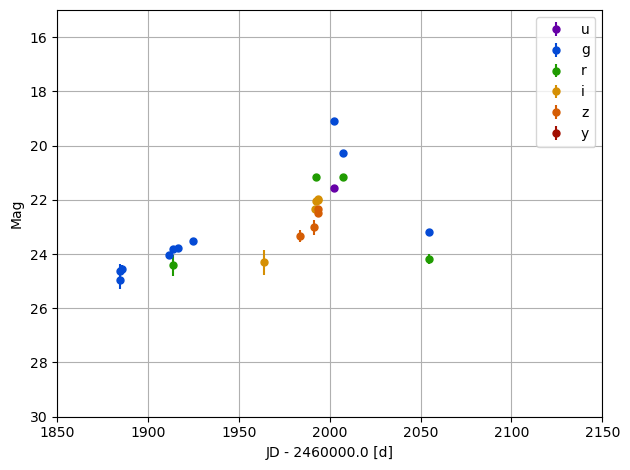

In [29]:
%matplotlib inline

dt = 2460000.0
plot_colors = {'u': '#6600a7', 'g': '#044ad5', 'r': '#209b01', 'i': '#d58f04', 'z': '#d55d04', 'y': '#a20f01'}

j=0
for telo in new_creation.telescopes:
    X = telo.lightcurve_flux['time'].value
    ym = mag(cero_p[j],telo.lightcurve_flux['flux'].value)
    z = []
    y = []
    x = []
    M5 = []
    for k in range(len(ym)):
        m5 = dataSlice['fiveSigmaDepth'][np.where(dataSlice['filter'] == filters[j])][k]
        magerr = signaltonoise.calc_mag_error_m5(ym[k],  LSST_BandPass[filters[j]], m5 , photParams)[0]
        sim_mag = np.random.normal(ym[k],magerr)
        if sim_mag <= mag_limit[j]:
            z.append(magerr)
            y.append(np.random.normal(ym[k],magerr))
            x.append(X[k] - dt)
            M5.append(m5)

    plt.errorbar(x,y,z,linestyle=' ',marker='.', markerfacecolor=plot_colors[fset[j]], 
                 markeredgecolor=plot_colors[fset[j]], markersize=10,
                 ecolor=plot_colors[fset[j]], label=fset[j])

    j += 1

#plt.axvspan(t0-params['tE']-dt, t0+params['tE']-dt, color='blue',alpha=0.3)

plt.gca().invert_yaxis()
[xmin, xmax, ymin, ymax] = plt.axis()
ymax = 15.0
ymin = 30.0
xmin = t0-(300/2.0)-dt
xmax = t0+(300/2.0)-dt
plt.axis([xmin,xmax,ymin,ymax])
plt.xlabel('JD - ' + str(dt) + ' [d]')
plt.ylabel('Mag')
plt.legend()
plt.grid()

#plt.show()
plt.tight_layout()
plt.savefig('/Users/rstreet/cassiopeia/GrantProposals/2024/NSF_AAG/figures/lsst_v4_sim_event.png')

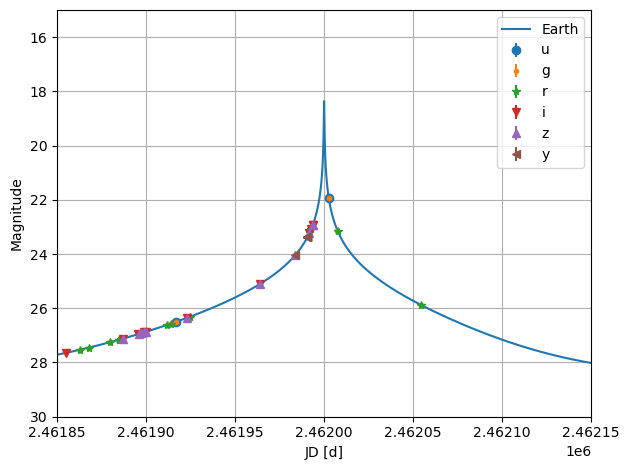

In [30]:
fig2, ax = plt.subplots()

pyLIMA_plots.plot_aligned_data(ax, my_own_model, my_own_parameters, bokeh_plot=None,
                      plot_unit='Mag')
pyLIMA_plots.plot_photometric_models(ax, my_own_model, my_own_parameters,
                            bokeh_plot=None, plot_unit='Mag')

plt.gca().invert_yaxis()
[xmin, xmax, ymin, ymax] = plt.axis()
ymax = 15.0
ymin = 30.0
xmin = t0-(300/2.0)
xmax = t0+(300/2.0)
plt.axis([xmin,xmax,ymin,ymax])

plt.xlabel('JD [d]')
plt.ylabel('Magnitude')

plt.grid()
plt.legend()

#plt.show()
plt.tight_layout()
plt.savefig('/Users/rstreet/cassiopeia/GrantProposals/2024/NSF_AAG/figures/lsst_v4_sim_event.png')